In [219]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from hydra import compose, initialize

from src.analysis.utils import (
    get_elsevier_single_column_fig,
    get_elsevier_one_and_half_column_fig,
    get_elsevier_double_column_fig,
    get_elsevier_figure_with_subplots
)
from src.modeling.utils import (
    regression_metrics
)

In [220]:
plt.rcParams.update({
    "font.size": 9,
    'lines.linewidth': 1,
})

SAVE_FIGURES = True

In [221]:
with initialize(version_base=None, config_path='../../src/conf'):
    cfg = compose(config_name="config")

In [222]:
figures_folder = Path('../../') / cfg['analysis']['figures_folder']

In [223]:
evaluation_results_dir = Path('../../') / cfg['modeling']['evaluation_results_dir']

target = "SOH"
model_name = "LGBMRegressor"
num_features = 4

evaluation_results_dir /= f"{num_features}_features_{model_name}_{target}_evaluation"
predictions_path = evaluation_results_dir / "predictions.csv"

In [224]:
predictions = pd.read_csv(predictions_path)

In [225]:
# predictions = predictions[(predictions["y_pred"]<3000) & (predictions["y_pred"]>0)]

In [226]:
def scatter_plot(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    model_name: str,
    target_name: str,
):
    """Plot y_true vs y_pred with regression line, ideal line, and metrics legend.

    Parameters
    ----------
    y_true : array-like
        True target values.
    y_pred : array-like
        Predicted target values.
    model_name : str
        Name of the model (for the title).
    target_name : str
        Name of the target variable (for the title).

    Returns
    -------
    tuple
        Plot's fig and ax.
    """
    metrics = regression_metrics(y_true, y_pred)

    # Compute metrics
    mae = metrics["mae"]
    rmse = metrics["rmse"]
    r2 = metrics["r2"]
    r = metrics["r"]

    # Fit regression line
    slope, intercept = np.polyfit(y_true, y_pred, 1)
    line_x = np.linspace(min(y_true), max(y_true), 100)
    reg_line = slope * line_x + intercept

    # Ideal line
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    ideal_line = np.linspace(min_val, max_val, 100)

    # Plot
    fig, ax = get_elsevier_one_and_half_column_fig(height_mm=120)
    ax.scatter(y_true, y_pred, alpha=0.5, label="Estimations", s=3)
    ax.plot(line_x, reg_line, label=f"Fit line\na={slope:.2f}\nb={intercept:.2f}", color="red", linestyle="--")
    ax.plot(ideal_line, ideal_line, label="Ideal (y = x)", color="black", linestyle="--")

    ax.set_xlabel(f"Reference {target_name}")
    ax.set_ylabel(f"Estimated {target_name}")
    ax.set_title(f"{model_name} - {num_features} features - {target_name} Estimation")

    # Add metrics to legend
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR: {r:.2f}\nR²: {r2:.2f}"
    ax.legend(title=metrics_text, loc="best")

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # ax.grid(True)
    return fig, ax

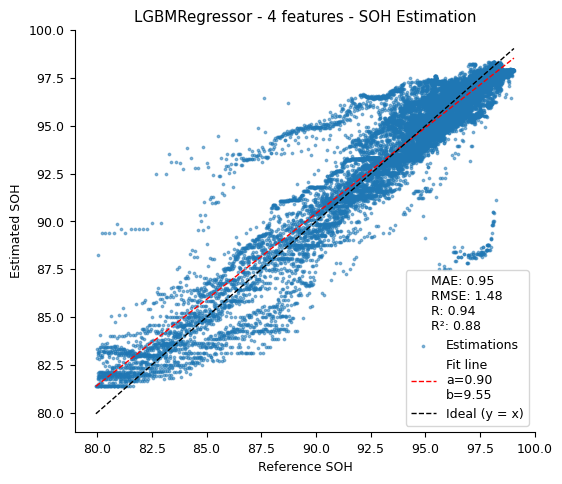

In [227]:
y_true = predictions["y_true"]
y_pred = predictions["y_pred"]

fig, ax = scatter_plot(y_true, y_pred, model_name, target)

if SAVE_FIGURES:
    fig.savefig(
        figures_folder 
        / f"{num_features}_features_{model_name}_{target}_scatter.png",
        dpi=300
    )

plt.show()

In [89]:
def cells_metrics_distribution(
    predictions: pd.DataFrame,
    model_name: str,
    target_name: str,
):
    """Plot y_true vs y_pred with regression line, ideal line, and metrics legend.

    Parameters
    ----------
    y_true : array-like
        True target values.
    y_pred : array-like
        Predicted target values.
    model_name : str
        Name of the model (for the title).
    target_name : str
        Name of the target variable (for the title).

    Returns
    -------
    tuple
        Plot's fig and ax.
    """
    cells_metrics = []
    for cell_name, cell in predictions.groupby("cell"):
        cell_metrics = regression_metrics(cell["y_true"], cell["y_pred"])
        cell_metrics["cell"] = cell_name
        cells_metrics.append(cell_metrics)

    cells_metrics = pd.DataFrame(cells_metrics)

    for metric in ["mae", "rmse", "r", "r2"]:
        # Plot
        fig, ax = get_elsevier_single_column_fig(height_mm=60)
        ax.hist(
            cells_metrics[metric], 
            bins=20,
            color="C0"
        )

        if metric in ["r", "r2"]:
            median = np.median(cells_metrics[metric])
            ax.axvline(
                median, 
                c="C1",
                linestyle="--",
                linewidth=2,
                label=f"Median: {median:.2f}"
                )

            q1 = np.percentile(cells_metrics[metric], q=25)
            ax.axvline(
                q1, 
                c="C2",
                linestyle="--",
                linewidth=2,
                label=f"Q1: {q1:.2f}"
                )
        else:
            median = np.median(cells_metrics[metric])
            ax.axvline(
                median, 
                c="C1",
                linestyle="--",
                linewidth=2,
                label=f"Median: {median:.2f} cycles"
                )

            q3 = np.percentile(cells_metrics[metric], q=75)
            ax.axvline(
                q3, 
                c="C2",
                linestyle="--",
                linewidth=2,
                label=f"Q3: {q3:.2f} cycles"
                )

        ax.set_xlabel(metric.upper())
        ax.set_ylabel(f"Number of Cells")
        ax.set_title(f"{model_name} - {target_name} {metric.upper()} Dist.")

        ax.legend(loc="best")

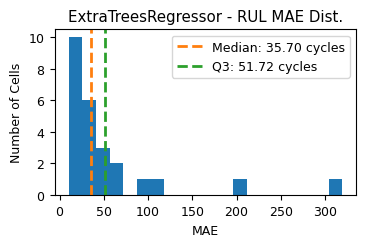

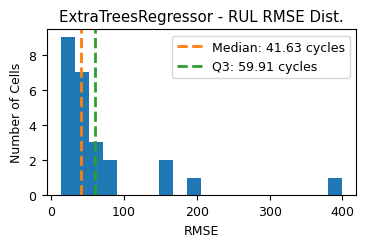

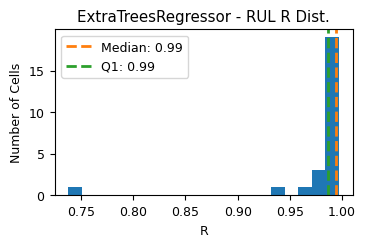

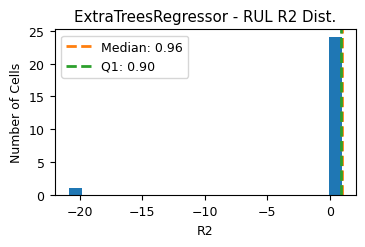

In [90]:
cells_metrics_distribution(predictions, model_name, target)

In [113]:
evaluation_results_dir = Path('../../') / cfg['modeling']['evaluation_results_dir']

all_predictions_df = []

for path in evaluation_results_dir.glob(pattern="*"):
    
    (
        num_features,
        _,
        model_name,
        target,
        _
    ) = path.stem.split("_")

    predictions_path = path / "predictions.csv"

    predictions = pd.read_csv(predictions_path)

    predictions = predictions[(predictions["y_pred"]<3000) & (predictions["y_pred"]>0)]

    predictions["target"] = target
    predictions["model_name"] = model_name
    predictions["num_features"] = num_features

    all_predictions_df.append(predictions)

all_predictions_df = pd.concat(all_predictions_df)

In [116]:
def Q1(g):
    return np.percentile(g, q=25)
def Q3(g):
    return np.percentile(g, q=75)

(
    all_predictions_df
    .groupby(["target", "model_name", "num_features", "cell"])
    .apply(lambda group: pd.DataFrame(
        regression_metrics(group["y_true"], group["y_pred"]),
        index=[0]
    ))
    .groupby(["target", "model_name", "num_features"])
    .agg(["mean", "median", Q1, Q3])
    .round(2)
)

/tmp/ipykernel_57831/2724685537.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.DataFrame(


mae                          rmse  \
                                          mean median     Q1      Q3    mean   
target model_name          num_features                                        
RUL    ExtraTreesRegressor 16            54.49  35.70  17.56   51.72   68.21   
                           4             58.24  32.17  23.33   52.45   74.90   
       KNeighborsRegressor 16            66.40  42.08  26.50   77.98   82.79   
                           4             67.32  43.91  36.43   67.41   89.54   
       LGBMRegressor       16            61.99  37.60  27.83   66.02   76.08   
                           4             64.24  42.30  27.02   56.23   82.32   
       TweedieRegressor    16            66.43  58.20  24.02   71.95   83.35   
                           4             84.17  76.06  43.80  106.15  102.77   
SOH    ExtraTreesRegressor 16             0.90   0.58   0.43    0.91    1.09   
                           4              1.15   0.79   0.63    1.12    1.42   
       KNeighborsRegressor 16             0.75   0.51   0.36    0.92    0.96   
                           4              1.04   0.80   0.49    1.04    1.34   
       LGBMRegressor       16             0.79   0.54   0.44    0.68    0.99   
                           4              1.04   0.71   0.53    1.06    1.32   
       TweedieRegressor    16             1.44   1.12   0.78    1.79    1.88   
                           4              1.60   1.45   0.88    1.88    1.93   

                                                                  r         \
                                        median     Q1      Q3  mean median   
target model_name          num_features                                      
RUL    ExtraTreesRegressor 16            41.63  22.63   59.91  0.98   0.99   
                           4             45.21  29.61   68.41  0.97   0.99   
       KNeighborsRegressor 16            54.17  34.55   95.94  0.96   0.98   
                           4             63.85  48.21  100.44  0.94   0.98   
       LGBMRegressor       16            49.46  35.97   76.74  0.97   0.99   
                           4             59.92  33.89   69.59  0.94   0.98   
       TweedieRegressor    16            63.52  31.67  102.68  0.96   0.99   
                           4             89.41  50.67  124.98  0.97   0.99   
SOH    ExtraTreesRegressor 16             0.83   0.57    0.97  0.99   0.99   
                           4              0.96   0.87    1.32  0.97   0.98   
       KNeighborsRegressor 16             0.69   0.49    1.14  0.98   0.99   
                           4              1.04   0.75    1.32  0.96   0.98   
       LGBMRegressor       16             0.71   0.58    0.80  0.99   0.99   
                           4              0.96   0.70    1.25  0.97   0.98   
       TweedieRegressor    16             1.36   1.03    2.33  0.94   0.98   
                           4              1.63   1.15    2.24  0.94   0.97   

                                                       r2                     
                                           Q1    Q3  mean median    Q1    Q3  
target model_name          num_features                                       
RUL    ExtraTreesRegressor 16            0.99  1.00  0.02   0.96  0.90  0.99  
                           4             0.98  0.99  0.28   0.96  0.91  0.98  
       KNeighborsRegressor 16            0.97  0.99 -0.57   0.93  0.79  0.97  
                           4             0.96  0.99  0.37   0.91  0.81  0.94  
       LGBMRegressor       16            0.99  0.99 -0.11   0.95  0.89  0.97  
                           4             0.97  0.99  0.25   0.93  0.91  0.95  
       TweedieRegressor    16            0.98  0.99  0.43   0.90  0.71  0.97  
                           4             0.98  0.99  0.49   0.85  0.60  0.93  
SOH    ExtraTreesRegressor 16            0.98  0.99  0.89   0.97  0.94  0.98  
                           4             0.97  0.99  0.83   0.95  0.89  0.96  
       KNeig

In [124]:
def Q1(g):
    return np.percentile(g, q=25)
def Q3(g):
    return np.percentile(g, q=75)

(
    all_predictions_df
    .groupby(["target", "model_name", "num_features", "cell"])
    .apply(lambda group: pd.DataFrame(
        regression_metrics(group["y_true"], group["y_pred"]),
        index=[0]
    ))
    .groupby(["target", "model_name", "num_features"])
    .agg({"rmse": ["median", Q3], "r2": ["median", Q1]})
    .round(2)
)

/tmp/ipykernel_57831/2639065218.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.DataFrame(


rmse             r2      
                                        median      Q3 median    Q1
target model_name          num_features                            
RUL    ExtraTreesRegressor 16            41.63   59.91   0.96  0.90
                           4             45.21   68.41   0.96  0.91
       KNeighborsRegressor 16            54.17   95.94   0.93  0.79
                           4             63.85  100.44   0.91  0.81
       LGBMRegressor       16            49.46   76.74   0.95  0.89
                           4             59.92   69.59   0.93  0.91
       TweedieRegressor    16            63.52  102.68   0.90  0.71
                           4             89.41  124.98   0.85  0.60
SOH    ExtraTreesRegressor 16             0.83    0.97   0.97  0.94
                           4              0.96    1.32   0.95  0.89
       KNeighborsRegressor 16             0.69    1.14   0.98  0.90
                           4              1.04    1.32   0.94  0.88
       LGBMRegressor       16             0.71    0.80   0.97  0.96
                           4              0.96    1.25   0.95  0.90
       TweedieRegressor    16             1.36    2.33   0.88  0.70
                           4              1.63    2.24   0.81  0.70

In [125]:
optimization_results_dir = Path('../../') / cfg['modeling']['optimization_results_dir']

all_histories_df = []

for path in optimization_results_dir.glob(pattern="*"):
    
    (
        num_features,
        _,
        model_name,
        target,
        _
    ) = path.stem.split("_")

    histories_path = path / "history.csv"

    histories = pd.read_csv(histories_path)

    histories["target"] = target
    histories["model_name"] = model_name
    histories["num_features"] = num_features

    all_histories_df.append(histories)

all_histories_df = pd.concat(all_histories_df)

In [136]:
all_histories_df["relative_gap"] = (
    (
        all_histories_df["train_rmse"] 
        - all_histories_df["val_rmse"]
    ).abs()
    / all_histories_df["val_rmse"]
)

In [139]:
(
    all_histories_df[all_histories_df["is_best_trial"]==True]
    .loc[:, ["target", "model_name", "num_features", "train_rmse", "val_rmse", "relative_gap"]]
    .round(2)
    .sort_values(["target", "model_name", "num_features"])
)

,target,model_name,num_features,train_rmse,val_rmse,relative_gap
0,RUL,ExtraTreesRegressor,16,31.38,103.64,0.70
0,RUL,ExtraTreesRegressor,4,52.33,110.00,0.52
0,RUL,KNeighborsRegressor,16,56.22,143.10,0.61
0,RUL,KNeighborsRegressor,4,51.19,112.09,0.54
0,RUL,LGBMRegressor,16,18.51,106.14,0.83
0,RUL,LGBMRegressor,4,22.12,109.09,0.80
0,RUL,TweedieRegressor,16,367.01,367.01,0.00
0,RUL,TweedieRegressor,4,337.10,340.03,0.01
0,SOH,ExtraTreesRegressor,16,0.78,1.07,0.27
0,SOH,ExtraTreesRegressor,4,1.23,1.40,0.12
